
## Yicheng May 2023

Import libraries, define filenames and folder paths:

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/MyDrive"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [2]:
import h5py
file_path = "ev0000364000.h5"

In [3]:
# Open the file
f = h5py.File(file_path, 'r')
f

<HDF5 file "ev0000364000.h5" (mode r)>

In [4]:
# List all the attributes for the file
list(f.attrs.keys())

['ele', 'lat', 'lon', 'mag', 'time']

In [5]:
# List of the stations
list(f.keys())

['IWEH', 'KI2H', 'MKJH', 'NMEH']

In [6]:
# Shape of the data for a station
dset = f['IWEH']
dset.shape

(3, 270000000)

In [7]:
dset.shape[1]/(100*60*60*24)

31.25

In [8]:
# List of attributes for the station
list(dset.attrs.keys())

['dist_m', 'ele', 'lat', 'lon']

In [9]:
# Access the distance in meters of the station from the event
print(dset.attrs['dist_m'],
dset.attrs['ele'],
dset.attrs['lat'],
dset.attrs['lon'])

0120189 -145 37.0264 140.9702


In [10]:
# Find the distance for all the stations
for k in f.keys():
    print(k,f[k].attrs['dist_m'])

IWEH 0120189
KI2H 0149570
MKJH 0149240
NMEH 0128023


In [11]:
# Extract a portion of the data from numerous stations

import numpy as np

# List of stations to consider
stations_list = ['IWEH', 'KI2H', 'MKJH','NMEH']

# Start and end index values for the portion of data to extract
# 24*3600*100 is 24 hours of data at 100 Hzone day of data.
# this example outputs firt hour of second day:
start = 24*3600*100
end = 25*3600*100

# Number of channels
num_channels = 3

# Allocate the space to save the extracted data
data = np.empty((len(stations_list),num_channels,end-start,))

for i in range(len(stations_list)):
    data[i,0:num_channels,:] = f[stations_list[i]][0:num_channels,start:end]
    
print(data.shape)

(4, 3, 360000)


In [12]:
# Save the extracted data to file
np.save('data1.npy', data)

In [13]:
# Use 5 seconds time window as cutoff for the first station and first channel

datadivided = list()
for i in range(720):#360000/100/5
    datadivided.append(data[0,0,500*i:500*(i+1)])


In [14]:
datadivided[666].shape

(500,)

In [15]:
%matplotlib inline
from matplotlib import pyplot as plt

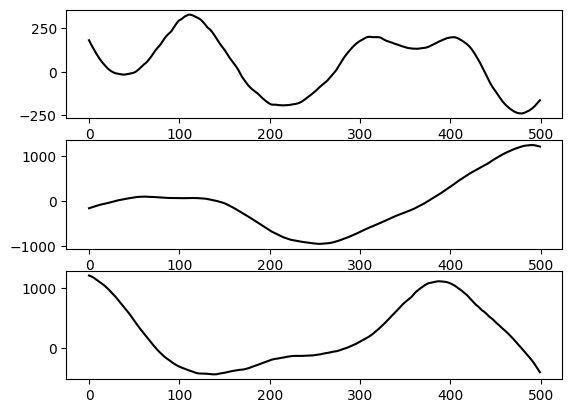

In [16]:
%matplotlib inline
fig,ax=plt.subplots(3)
ax[0].plot(datadivided[0],'k-')
ax[1].plot(datadivided[1],'k-')
ax[2].plot(datadivided[2],'k-')

Use obspy library to apply 1HZ high-pass filter

In [17]:
pip install obspy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [18]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, ifft
from scipy.fft import fft, fftfreq
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
from pylab import plot, xlabel, ylabel
from scipy import arange
from scipy import signal
import obspy as ob
import time
import warnings
#import ipywidgets as widgets
#from ipywidgets import *
warnings.filterwarnings('ignore')

In [19]:
fq=100.0 # frequency of input signal\n",

In [20]:
tr=ob.Trace(datadivided[0]) # turn the data in obspy formatted trace
tr.stats.delta = 1/fq  # give trace time sampling size
trf=tr.filter("highpass", freq=1.0)   # apply high-pass filter

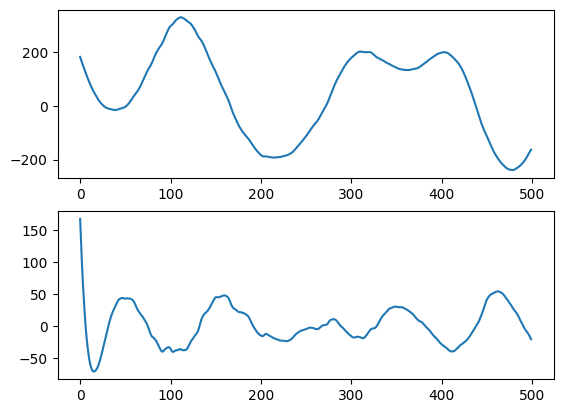

In [21]:
%matplotlib inline
fig,ax=plt.subplots(2)
ax[0].plot(datadivided[0]);
ax[1].plot(trf);

In [22]:
datafiltered = list()

for i in range(len(datadivided)): 
    tr=ob.Trace(datadivided[i]) # turn the data in obspy formatted trace
    tr.stats.delta = 1/fq  # give trace time sampling size
    datafiltered.append(tr.filter("highpass", freq=1.0).data)  # apply high-pass filter

Featrue Extraction

In [23]:
print(len(datafiltered))

type(datafiltered[0])

720


numpy.ndarray

For each waveform, feature vectors are calculated to use in clustering analysis. The data features are time and frequency domain scalar values that include the integral of the squared waveform, maximum spectral amplitude, frequency at the maximum spectral amplitude, center frequency, signal bandwidth, zero upcrossing rate, and the rate of spectral peaks

First using fourier transform to get the frequency domain values

In [24]:

fs=100#HZ sampling freq
t= np.arange(0,5,1/fs) #time interval
f = 100;# signal freq
# generate frequency axis 
n=np.size(t)# number of samples
fi = np.linspace(0,int(fs/2),int(n/2))#freq interval

datafft = list()#spectral_amplitudes

# Calculate the Fourier transform of the waveform
for i in range(len(datafiltered)):
    datafft.append(fft(datafiltered[i])[0: int(n/2)])# #spectral_amplitudes


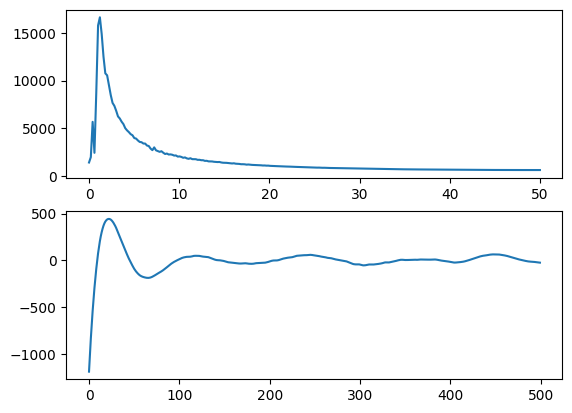

In [25]:
%matplotlib inline
fig,ax=plt.subplots(2)
ax[0].plot(fi,np.abs(datafft[10]));
ax[1].plot(datafiltered[10]); 

Get the intergral of squared waveform

In [26]:
integral = list()
for i in range(len(datafiltered)):
    # Get the waveform data
    data = datafiltered[i]

    # Square the waveform data
    data_squared = data ** 2

    # Calculate the integral of the squared data
    integral.append(np.sum(data_squared))

Max spectral amplitude:

Frequency of max spectral amplitude:

In [27]:
#Assuming Fx is a list or array containing the spectral amplitudes and fi is a corresponding list or array containing the frequencies, 
#this code finds the index of the maximum amplitude and retrieves the corresponding frequency.
max_indices = []
max_amplitudes = []
for array in datafft:
    max_index = np.argmax(array)
    max_indices.append(max_index)
    max_amplitudes.append(array[max_index].real)

# Retrieve the corresponding frequencies
frequencies = [fi[index] for index in max_indices]

Center frequency:

In [28]:
#Assuming fi and Fxi are lists or arrays representing frequencies and corresponding 
#spectral amplitudes, respectively, this code calculates the center frequency 
#using the given equation.
center_frequency = list()
for i in range(len(datafiltered)):
    numerator = np.sum(fi * datafft[i]).real
    denominator = np.sum(datafft[i]).real
    center_frequency.append(numerator / denominator)

Signal bandwidth:

In [29]:
# Assuming fi and Fxi are lists or arrays representing frequencies and corresponding spectral amplitudes, 
# and fcenter is the center frequency, this code calculates the signal bandwidth using the given equation.
signal_bandwidth = list()
for i in range(len(datafiltered)):
    numerator = np.sum((fi - center_frequency[i])**2)
    denominator = np.sum(datafft[i])
    signal_bandwidth.append(np.sqrt(numerator / denominator).real)

Zero up-crossing rate:

In [30]:
# Assuming fi and Fxi are lists or arrays representing frequencies and corresponding 
# spectral amplitudes, this code calculates the zero up-crossing rate using the given equation.
zero_upcrossing_rate = list()
for i in range(len(datafiltered)):
    omega = 2 * np.pi * fi
    numerator = np.sum(omega**2 * datafft[i]**2)
    denominator = np.sum(datafft[i]**2)
    zero_upcrossing_rate.append(np.sqrt(numerator / denominator).real)

Rate of spectral peaks:

In [31]:
#Assuming fi and Fxi are lists or arrays representing frequencies and corresponding 
#spectral amplitudes, this code calculates the rate of spectral peaks using the given equation.
rate_of_spectral_peaks = list()
for i in range(len(datafiltered)):
    omega = 2 * np.pi * fi
    numerator = np.sum(omega**4 * datafft[i]**2)
    denominator = np.sum(omega**2 * datafft[i]**2)
    rate_of_spectral_peaks.append(np.sqrt(numerator / denominator).real)

PCA

In [32]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

df = pd.DataFrame(list(zip(integral, max_amplitudes, frequencies, center_frequency, signal_bandwidth,zero_upcrossing_rate,rate_of_spectral_peaks)), 
                  columns = ['integral of the squared waveform', 'maximum spectral amplitude', 'frequency at the maximum spectral amplitude', 
                             'center frequency', 'signal bandwidth', 'zero upcrossing rate', 'rate of spectral peaks'])
df

,integral of the squared waveform,maximum spectral amplitude,frequency at the maximum spectral amplitude,center frequency,signal bandwidth,zero upcrossing rate,rate of spectral peaks
0,4.450727e+05,3831.371137,0.602410,17.909420,1.138306,38.861817,210.892013
1,2.753136e+05,2733.794517,1.004016,14.404091,0.217624,18.367710,213.595169
2,8.620127e+06,12587.276384,1.606426,16.387972,0.448876,70.184974,211.661191
3,1.625990e+06,1468.060150,0.401606,14.761540,0.243128,48.683488,212.599692
4,1.173240e+07,9882.829957,0.803213,15.940552,0.113902,103.767189,211.904864
...,...,...,...,...,...,...,...
715,6.465616e+05,5122.009891,1.004016,24.357529,0.671480,5.392850,211.860387
716,1.275258e+06,2565.640454,0.803213,14.276447,0.212875,52.077327,211.846341
717,1.496874e+07,15099.423116,1.807229,16.124562,0.402103,85.612212,211.400923
718,6.736727e+05,4871.738246,1.405622,16.409619,0.932964,52.706116,211.131912


In [33]:
df.corr()

,integral of the squared waveform,maximum spectral amplitude,frequency at the maximum spectral amplitude,center frequency,signal bandwidth,zero upcrossing rate,rate of spectral peaks
integral of the squared waveform,1.000000,0.833729,0.096546,-0.014141,-0.109639,0.393205,0.074140
maximum spectral amplitude,0.833729,1.000000,0.244202,-0.009803,-0.125211,0.404194,0.081362
frequency at the maximum spectral amplitude,0.096546,0.244202,1.000000,-0.036427,0.008501,0.130934,0.100722
center frequency,-0.014141,-0.009803,-0.036427,1.000000,0.603751,-0.039286,0.025968
signal bandwidth,-0.109639,-0.125211,0.008501,0.603751,1.000000,-0.192756,-0.089442
zero upcrossing rate,0.393205,0.404194,0.130934,-0.039286,-0.192756,1.000000,0.179387
rate of spectral peaks,0.074140,0.081362,0.100722,0.025968,-0.089442,0.179387,1.000000


In [34]:
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is named 'df'
X = df

# Splitting the dataset into training and evaluation sets
X_train, X_eval = train_test_split(X, test_size=0.1, random_state=66)

In [35]:
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_eval_std = scaler.transform(X_eval)

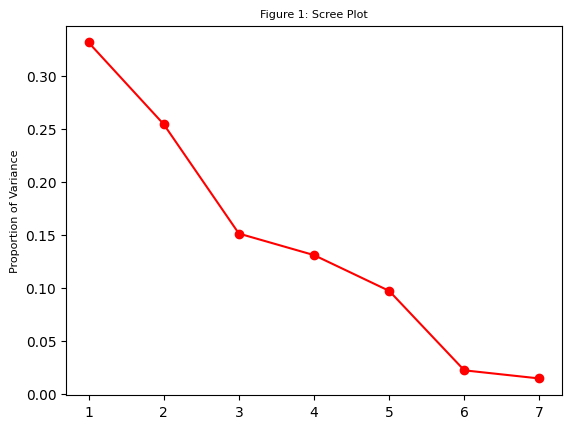

array([0.33124438, 0.25409438, 0.15096787, 0.13063609, 0.09688417,
       0.02192669, 0.01424642])

In [36]:
pca = PCA(n_components=7)
X_train_pca = pca.fit_transform(X_train_std)
X_eval_pca = pca.transform(X_eval_std)

# Checking the explained variance ratio
prop_var = pca.explained_variance_ratio_
eigenvalues = pca.explained_variance_
PC_numbers = np.arange(pca.n_components_) + 1
 
plt.plot(PC_numbers, 
         prop_var, 
         'ro-')
plt.title('Figure 1: Scree Plot', fontsize=8)
plt.ylabel('Proportion of Variance', fontsize=8)
plt.show()
pca.explained_variance_ratio_

In [37]:
from scipy.linalg import sqrtm

# Compute the covariance matrix
covariance_matrix = np.cov(X_train_pca, rowvar=False)

# Calculate the correlation matrix
correlation_matrix = np.corrcoef(X_train_pca.T)

# Compute the whitening matrix
whitening_matrix = sqrtm(np.linalg.inv(covariance_matrix))

# Apply whitening to the PCA components
X_train_whitened = np.dot(X_train_pca, whitening_matrix)
X_eval_whitened = np.dot(X_eval_pca, whitening_matrix)

cm = pd.DataFrame(correlation_matrix)
cm


,0,1,2,3,4,5,6
0,1.000000e+00,1.943783e-16,2.801952e-17,-1.901397e-16,-4.809270e-17,6.203404e-17,-1.368174e-16
1,1.943783e-16,1.000000e+00,-5.598548e-17,3.439126e-17,-4.018455e-16,-1.442799e-17,-1.952666e-16
2,2.801952e-17,-5.598548e-17,1.000000e+00,-8.644602e-17,3.464753e-16,9.188870e-17,-1.351083e-16
3,-1.901397e-16,3.439126e-17,-8.644602e-17,1.000000e+00,2.784769e-16,-1.317078e-16,9.077634e-17
4,-4.809270e-17,-4.018455e-16,3.464753e-16,2.784769e-16,1.000000e+00,-2.602078e-17,1.317613e-16
5,6.203404e-17,-1.442799e-17,9.188870e-17,-1.317078e-16,-2.602078e-17,1.000000e+00,4.431469e-17
6,-1.368174e-16,-1.952666e-16,-1.351083e-16,9.077634e-17,1.317613e-16,4.431469e-17,1.000000e+00


KMean

In [ ]:
# Some variables
SAMPLE_SIZE = 0.1
RANDOM_STATE = 42
NUM_CLUSTERS = 10     # k
NUM_ITER = 3          # n
NUM_ATTEMPTS = 5      # m
data_sample = data.sample(frac=SAMPLE_SIZE, random_state=RANDOM_STATE, replace=False)
data_sample.shape

In [ ]:
final_cents = []
final_inert = []
    
for sample in range(NUM_ATTEMPTS):
    print('\nCentroid attempt: ', sample)
    km = KMeans(n_clusters=NUM_CLUSTERS, init='random', max_iter=1, n_init=1)#, verbose=1) 
    km.fit(data_sample)
    inertia_start = km.inertia_
    intertia_end = 0
    cents = km.cluster_centers_
        
    for iter in range(NUM_ITER):
        km = KMeans(n_clusters=NUM_CLUSTERS, init=cents, max_iter=1, n_init=1)
        km.fit(data_sample)
        print('Iteration: ', iter)
        print('Inertia:', km.inertia_)
        print('Centroids:', km.cluster_centers_)
        inertia_end = km.inertia_
        cents = km.cluster_centers_
    final_cents.append(cents)
    final_inert.append(inertia_end)
    print('Difference between initial and final inertia: ', inertia_start-inertia_end)

In [ ]:
# Get best centroids to use for full clustering
best_cents = final_cents[final_inert.index(min(final_inert))]
best_cents

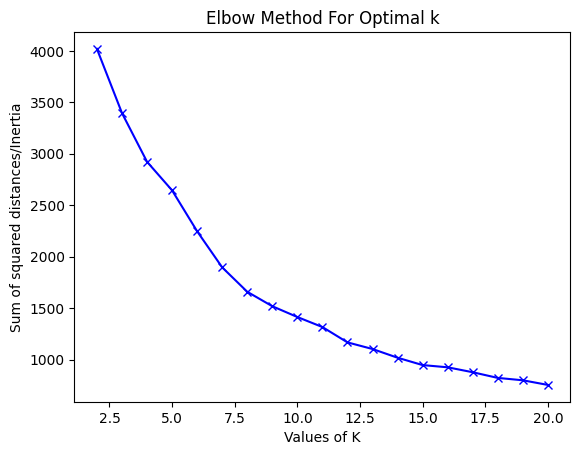

In [38]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics import pairwise_distances

# Elbow Method for optimal number of clusters


Sum_of_squared_distances = []
K = range(2,21)
for num_clusters in K :
 kmeans = KMeans(n_clusters=num_clusters)
 kmeans.fit(X_train_whitened)
 Sum_of_squared_distances.append(kmeans.inertia_)
plt.plot(K,Sum_of_squared_distances,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Sum of squared distances/Inertia') 
plt.title('Elbow Method For Optimal k')
plt.show()


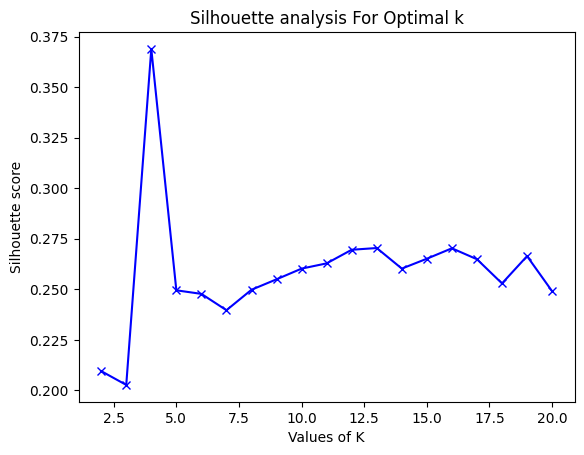

In [39]:
from sklearn.metrics import silhouette_score
silhouette_avg = []
for num_clusters in K:
  # initialise kmeans
  kmeans = KMeans(n_clusters=num_clusters)
  kmeans.fit(X_train_whitened)
  cluster_labels = kmeans.labels_
  # silhouette score
  silhouette_avg.append(silhouette_score(X_train_whitened, cluster_labels))
plt.plot(K,silhouette_avg,'bx-')
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Silhouette analysis For Optimal k')
plt.show()

In [40]:
!pip install git+https://github.com/milesgranger/gap_statistic.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/milesgranger/gap_statistic.git to /tmp/pip-req-build-bw8l_xxh
  Running command git clone --filter=blob:none --quiet https://github.com/milesgranger/gap_statistic.git /tmp/pip-req-build-bw8l_xxh
  Resolved https://github.com/milesgranger/gap_statistic.git to commit d5f8a8ec719fa8c33caa68a957e90feedd80475f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gap-stat: filename=gap_stat-2.0.2-py3-none-any.whl size=6079 sha256=30ad12d58bcfd472a335025a0387df4359465174c076116aa6cee43c916045c2
  Stored in directory: /tmp/pip-ephem-wheel-cache-pvv313ed/wheels/23/de/a0/364cf1dc6cc8534993f78aeaf84fabf8496481fd7ae5ac31ff
Successfully built gap-stat


In [41]:
pip install --upgrade gap-stat

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [51]:
from gap_statistic import OptimalK
from sklearn.cluster import KMeans
def KMeans_clustering_func(X, k):
    """ 
    K Means Clustering function, which uses the K Means model from sklearn.
    
    These user-defined functions *must* take the X (input features) and a k 
    when initializing OptimalK
    """
    
    # Include any clustering Algorithm that can return cluster centers
    
    m = KMeans(random_state=11, n_clusters=k)
    m.fit(X)
    
    # Return the location of each cluster center,
    # and the labels for each point.
    return m.cluster_centers_, m.predict(X)
#--------------------create a wrapper around OptimalK to extract cluster centers and cluster labels
optimalK = OptimalK(clusterer=KMeans_clustering_func)
#--------------------Run optimal K on the input data (subset_scaled_interim) and number of clusters
n_clusters = optimalK(X_train_whitened, cluster_array=np.arange(2, 21))
print('Optimal clusters: ', n_clusters)
#--------------------Gap Statistics data frame
optimalK.gap_df[['n_clusters', 'gap_value']]


Optimal clusters:  20


,n_clusters,gap_value
0,2.0,2.962542
1,3.0,2.900143
2,4.0,2.935292
3,5.0,3.036373
4,6.0,3.133980
5,7.0,3.232189
6,8.0,3.310485
7,9.0,3.366886
8,10.0,3.424726
9,11.0,3.454131


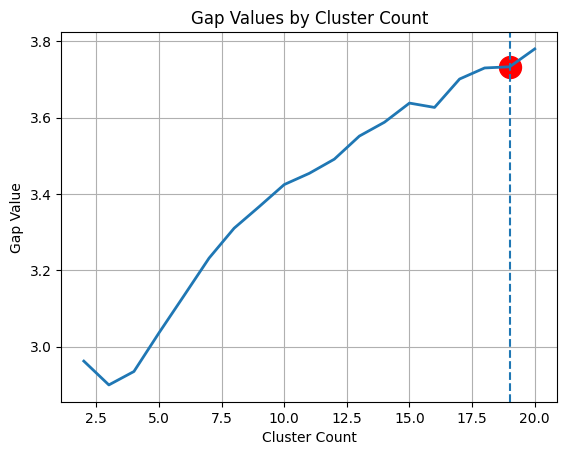

In [53]:

n_clusters=19
plt.plot(optimalK.gap_df.n_clusters, optimalK.gap_df.gap_value, linewidth=2)
plt.scatter(optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].n_clusters,
            optimalK.gap_df[optimalK.gap_df.n_clusters == n_clusters].gap_value, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.axvline(19, linestyle="--")
plt.show()

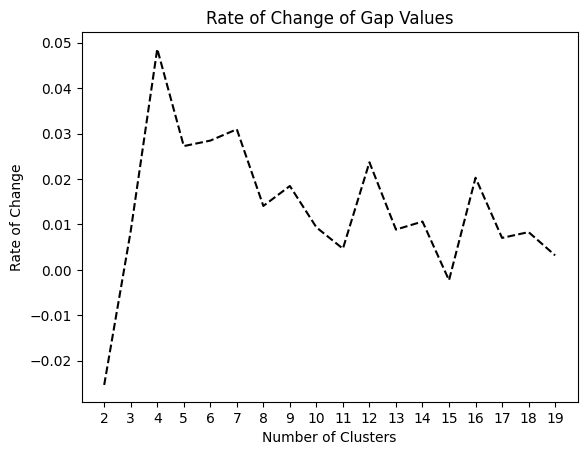

In [44]:
# Calculate the differences between consecutive gap values
gap_differences = np.diff(optimalK.gap_df['gap_value'])

# Calculate the rate of change
rate_of_change = np.divide(gap_differences, optimalK.gap_df['gap_value'][:-1])

# Plot the rate of change
plt.plot(range(2, 20), rate_of_change, color='black', linestyle='dashed', label='Rate of Change')
plt.xticks(range(2, 20))
# Set the plot title and labels
plt.title('Rate of Change of Gap Values')
plt.xlabel('Number of Clusters')
plt.ylabel('Rate of Change')

# Display the plot
plt.show()


Second Method

In [57]:
import scipy
import scipy.cluster.vq
import scipy.spatial.distance
dst = scipy.spatial.distance.euclidean


def optimalK(data, nrefs=50, maxClusters=20):
    """
    Calculates KMeans optimal K using Gap Statistic from Tibshirani, Walther, Hastie
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        
        origDisp = km.inertia_
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)  # Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal

range(0, 10)

Optimal k is:  19


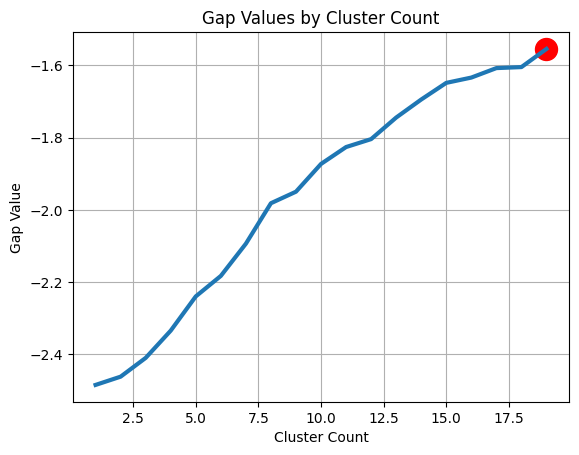

In [46]:
# Automatically output the number of clusters
k, gapdf = optimalK(X_train_whitened, nrefs=720, maxClusters=20)
print('Optimal k is: ', k)
# Visualization
plt.plot(gapdf.clusterCount, gapdf.gap, linewidth=3)
plt.scatter(gapdf[gapdf.clusterCount == k].clusterCount, gapdf[gapdf.clusterCount == k].gap, s=250, c='r')
plt.grid(True)
plt.xlabel('Cluster Count')
plt.ylabel('Gap Value')
plt.title('Gap Values by Cluster Count')
plt.show()

In [58]:
gapdf

,clusterCount,gap
0,1.0,-2.484628
1,2.0,-2.461759
2,3.0,-2.409818
3,4.0,-2.334371
4,5.0,-2.239624
5,6.0,-2.182918
6,7.0,-2.093725
7,8.0,-1.981723
8,9.0,-1.949781
9,10.0,-1.872955


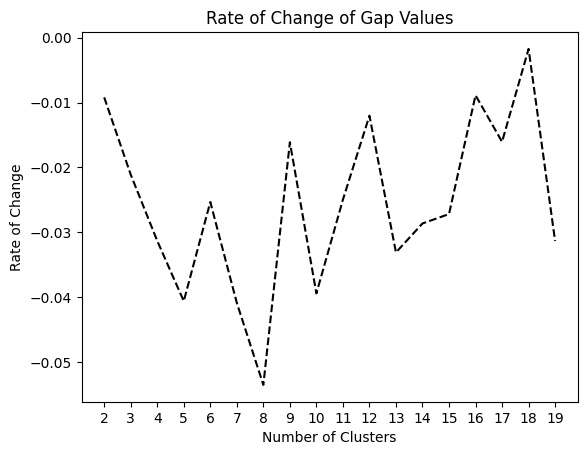

In [48]:
# Calculate the differences between consecutive gap values
gap_differences = np.diff(gapdf['gap'])

# Calculate the rate of change
rate_of_change = np.divide(gap_differences, gapdf['gap'][:-1])

# Plot the rate of change
plt.plot(range(2, 20), rate_of_change, color='black', linestyle='dashed', label='Rate of Change')

plt.xticks(range(2, 20))

# Set the plot title and labels
plt.title('Rate of Change of Gap Values')
plt.xlabel('Number of Clusters')
plt.ylabel('Rate of Change')

# Display the plot
plt.show()
